<a href="https://colab.research.google.com/github/Jian-Chueng/Book/blob/master/traffic_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs
  

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [3]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


test.p  train.p	valid.p: pickled files\
"pickled files": can be serialized before writing the file.\
By serializing it, it converts all the object to a character stream.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

from keras.callbacks import LearningRateScheduler, ModelCheckpoint

Using TensorFlow backend.


In [0]:
%matplotlib inline
# Provided you are running IPython, 
# the %matplotlib inline will make your plot outputs appear and 
# be stored within the notebook.

In [0]:
np.random.seed(0)


In [7]:
# TODO: Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
print(type(test_data))



<class 'dict'>


In [0]:
# Split out features and labels
X_train, y_train = train_data['features'],train_data['labels']
X_val, y_val = val_data['features'],val_data['labels']
X_test, y_test = test_data['features'],test_data['labels']

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
#already 4 dimensional

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


we have 34799 images in our training sets, where each image
has dimensions of 32 by 32 pixels, and also each one having a depth of 3 (RGB: 3 channels)\
we have 4410 images in our validation sets, where each image has dimensions of 32 by 32 pixels, and also each one having a depth of 3 (RGB: 3 channels)\
we have 12630 images in our test sets, where each image has dimensions of 32 by 32 pixels, and also each one having a depth of 3 (RGB: 3 channels)

In [0]:
# images numbers = labels number
assert(X_train.shape[0] == y_train.shape[0]),"The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]),"The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]),"The number of images is not equal to the number of labels"
# dimension is 32 x 32 x 3
assert(X_train.shape[1:] == (32, 32, 3)),"The dimensions of images is not 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)),"The dimensions of images is not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)),"The dimensions of images is not 32 x 32 x 3"


In [11]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)
print(type(data))

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

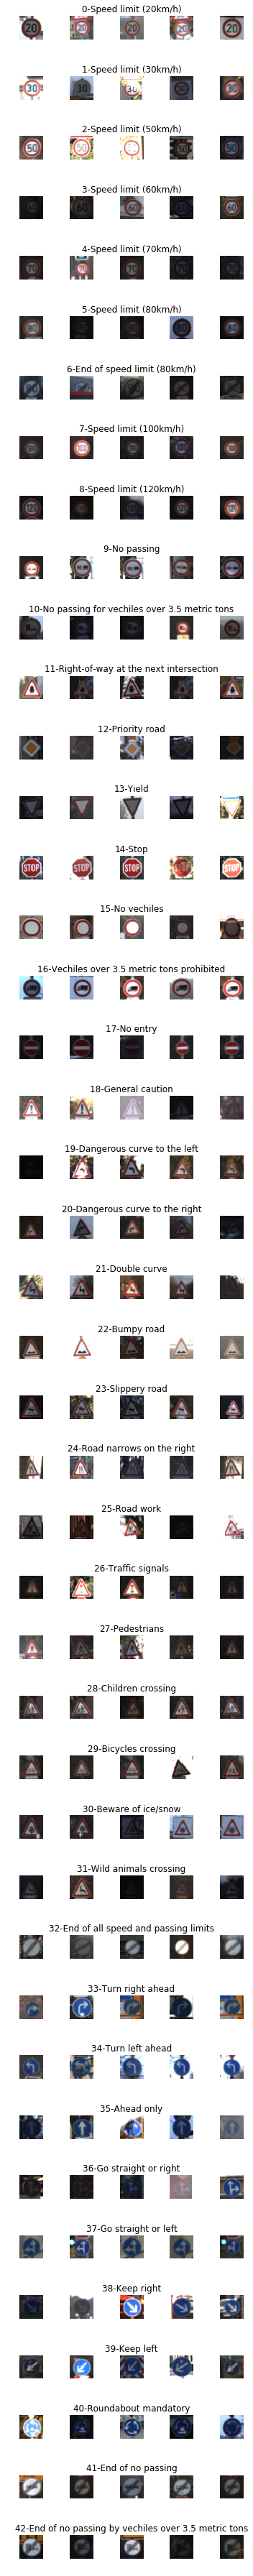

In [12]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
    for j,row in data.iterrows():#only for DataFrame,(index, series)
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+'-' + row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


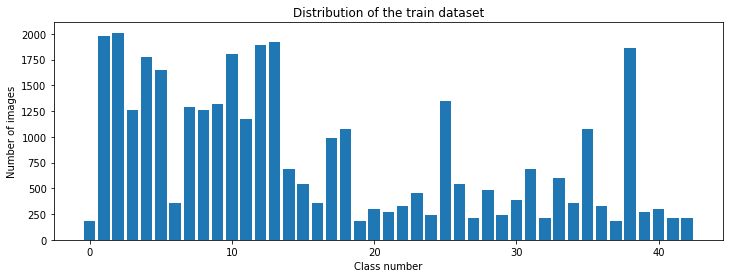

In [13]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

**This traffic sign data is much uniform: some classes have less data to train with and might return less accurate results**

label: 36


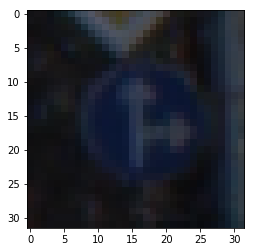

In [40]:
import cv2
img = X_train[1000]
plt.imshow(img) 
plt.axis('on')
print('label:', y_train[1000])


why define "grayscale" function:\
Color is not very significant feature to look for, as the lighting in out image varies and many traffic signs has similar colors\
use"grayscale" to focus on edges, curves, and only one channel require less parameters


(32, 32)


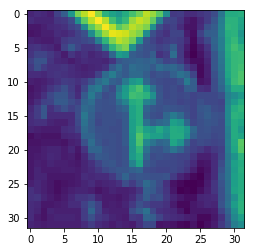

In [41]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis('off')
print(img.shape)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray)
# print(img.shape)

pixel intensities are bunched up around the small range of brightness values histogram(原来窄长)

**equalization**： takes our histogram(原来窄长) and spreads it at the ends to get a histogram（宽矮） that covers **a higher range of brightness** values and helps to *normalize the lighting* and all of our images.（宽矮）

This process also results in higher contrast with our image which can help with feature extraction.


In [0]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

(32, 32)


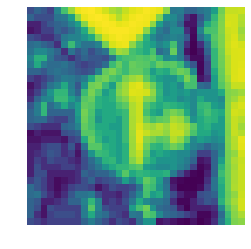

In [43]:
img= equalize(img)
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)
(4410, 32, 32)
(12630, 32, 32)


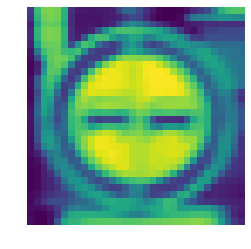

In [53]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)


In [56]:
y_train = to_categorical(y_train, 43)
y_train = to_categorical(y_train, 43)
y_train = to_categorical(y_train, 43)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)
